In [2]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

from PIL import Image
import torchvision.transforms as transforms


In [3]:
# Example: read the parquet from huggingface
splits = {
    'train': 'plain_text/train-00000-of-00001.parquet',
    'test' : 'plain_text/test-00000-of-00001.parquet'
}

df_train_full = pd.read_parquet("hf://datasets/uoft-cs/cifar10/" + splits["train"])
print("Full train dataframe shape:", df_train_full.shape)
print(df_train_full.head())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Full train dataframe shape: (50000, 2)
                                                 img  label
0  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      0
1  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      6
2  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      0
3  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      2
4  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      7


In [4]:
NUM_CLASSES = 10

class CifarHFDataset(Dataset):
    def __init__(self, df, transform=None, one_hot=True):
        """
        df must have columns 'img' (dict {'bytes':...}) and 'label' (int).
        transform: a torchvision transform (for images).
        one_hot: if True, convert label to one-hot vector of size NUM_CLASSES.
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.one_hot = one_hot

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # 1) Convert bytes to PIL image
        img_bytes = row["img"]["bytes"]  # dictionary -> 'bytes'
        pil_image = Image.open(io.BytesIO(img_bytes)).convert("RGB")

        # 2) Transform (scale or augment)
        if self.transform:
            img_tensor = self.transform(pil_image)
        else:
            # Convert to tensor if no transform is given
            img_tensor = transforms.ToTensor()(pil_image)  # shape [3,32,32]

        # 3) One-hot encode the label
        label_int = row["label"]
        if self.one_hot:
            # shape => [NUM_CLASSES], e.g. [0,0,0,0,0,0,0,0,0,1] for label 9
            label_vector = torch.zeros(NUM_CLASSES)
            label_vector[label_int] = 1.0
            return img_tensor, label_vector
        else:
            # Just return integer label
            return img_tensor, label_int


In [5]:
# 80% train, 20% test
df_train, df_test = train_test_split(
    df_train_full,
    test_size=0.2,
    random_state=42,
    stratify=df_train_full["label"]
)
print("Train size:", len(df_train), "Test size:", len(df_test))


Train size: 40000 Test size: 10000


In [6]:
# No Augmentation: just scale [0..255] to [0..1]
# We'll further standardize by (mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) if you want
noaug_transform = transforms.Compose([
    transforms.ToTensor(),  # convert [0..255] to float [0..1]
    # transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # optional normalization
])

# With Augmentation (flip, random rotation):
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


In [7]:
# No Augmentation: just scale [0..255] to [0..1]
# We'll further standardize by (mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) if you want
noaug_transform = transforms.Compose([
    transforms.ToTensor(),  # convert [0..255] to float [0..1]
    # transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # optional normalization
])

# With Augmentation (flip, random rotation):
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


In [8]:
train_dataset_noaug = CifarHFDataset(df_train, transform=noaug_transform, one_hot=True)
test_dataset_noaug  = CifarHFDataset(df_test,  transform=noaug_transform,  one_hot=True)

train_loader_noaug = DataLoader(train_dataset_noaug, batch_size=32, shuffle=True, num_workers=2)
test_loader_noaug  = DataLoader(test_dataset_noaug,  batch_size=32, shuffle=False, num_workers=2)


In [9]:
train_dataset_aug = CifarHFDataset(df_train, transform=aug_transform, one_hot=True)
test_dataset_aug  = CifarHFDataset(df_test,  transform=noaug_transform, one_hot=True)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True, num_workers=2)
test_loader_aug  = DataLoader(test_dataset_aug,  batch_size=32, shuffle=False, num_workers=2)


In [10]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        # First 3 conv layers
        self.conv1 = nn.Conv2d(3,   32, kernel_size=3, padding=1)  # => (B,32,32,32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)   # => (B,64,32,32)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)   # => (B,64,32,32)

        self.pool1 = nn.MaxPool2d(2, 2)  # Halve spatial size => (B,64,16,16)

        # Next 2 conv layers
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # => (B,128,16,16)
        self.conv5 = nn.Conv2d(128,128, kernel_size=3, padding=1)  # => (B,128,16,16)

        self.pool2 = nn.MaxPool2d(2, 2)  # => (B,128,8,8)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # First block of convs
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool1(x)  # => (B,64,16,16)

        # Second block of convs
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool2(x)  # => (B,128,8,8)

        # Flatten
        x = x.view(x.size(0), -1)  # => (B,128*8*8)
        x = F.relu(self.fc1(x))    # => (B,256)
        x = self.fc2(x)            # => (B,10)
        return x

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # => (32 x 32 x 32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # => (64 x 32 x 32)
        self.pool  = nn.MaxPool2d(2,2)                           # => (64 x 16 x 16)

        self.fc1   = nn.Linear(64*16*16, 256)
        self.fc2   = nn.Linear(256, NUM_CLASSES)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # shape => (32,32,32)
        x = F.relu(self.conv2(x))   # shape => (64,32,32)
        x = self.pool(x)            # shape => (64,16,16)
        x = x.view(x.size(0), -1)   # flatten
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)        # shape => [batch, 10], no softmax needed
        return logits


In [12]:
def train_model(train_loader, test_loader, num_epochs=10, lr=0.001, cnn_type="simple"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    if cnn_type == "simple":
        model = SimpleCNN().to(device)
    else:
        model = DeeperCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        # -- TRAIN --
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)           # shape [batch, 10]
            loss = criterion(outputs, labels) # both [batch, 10]
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            # For accuracy, compare argmax of outputs vs. argmax of label
            preds = torch.argmax(outputs, dim=1)
            target_class = torch.argmax(labels, dim=1)
            total += labels.size(0)
            correct += (preds == target_class).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # -- EVAL/TEST --
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                target_class = torch.argmax(labels, dim=1)
                total += labels.size(0)
                correct += (preds == target_class).sum().item()

        epoch_test_loss = running_loss / len(test_loader.dataset)
        epoch_test_acc = correct / total
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | "
              f"Test Loss: {epoch_test_loss:.4f}, Acc: {epoch_test_acc:.4f}")

    return model, (train_losses, test_losses, train_accuracies, test_accuracies)


In [13]:
print("=== Training WITHOUT Data Augmentation with a Simple CNN ===")
model_noaug, metrics_noaug = train_model(
    train_loader_noaug,
    test_loader_noaug,
    num_epochs=10,
    lr=0.001
)

print("\n=== Training WITH Data Augmentation with a Simple CNN ===")
model_aug, metrics_aug = train_model(
    train_loader_aug,
    test_loader_aug,
    num_epochs=10,
    lr=0.001
)


print("=== Training WITHOUT Data Augmentation with a Deeper CNN ===")
model_noaug_deeper, metrics_noaug_deeper = train_model(
    train_loader_noaug,
    test_loader_noaug,
    num_epochs=10,
    lr=0.001,
    cnn_type="5 layer"
)

print("\n=== Training WITH Data Augmentation with a Deeper CNN ===")
model_aug_deeper, metrics_aug_deeper = train_model(
    train_loader_aug,
    test_loader_aug,
    num_epochs=10,
    lr=0.001,
    cnn_type="5 layer"
)


=== Training WITHOUT Data Augmentation with a Simple CNN ===
Using device: cuda
Epoch [1/10] | Train Loss: 1.4020, Acc: 0.4951 | Test Loss: 1.1495, Acc: 0.5942
Epoch [2/10] | Train Loss: 0.9981, Acc: 0.6476 | Test Loss: 1.0067, Acc: 0.6483
Epoch [3/10] | Train Loss: 0.7880, Acc: 0.7226 | Test Loss: 0.9616, Acc: 0.6652
Epoch [4/10] | Train Loss: 0.6184, Acc: 0.7832 | Test Loss: 0.9278, Acc: 0.6891
Epoch [5/10] | Train Loss: 0.4537, Acc: 0.8415 | Test Loss: 1.0585, Acc: 0.6775
Epoch [6/10] | Train Loss: 0.3147, Acc: 0.8896 | Test Loss: 1.1560, Acc: 0.6778
Epoch [7/10] | Train Loss: 0.2022, Acc: 0.9295 | Test Loss: 1.3895, Acc: 0.6755
Epoch [8/10] | Train Loss: 0.1367, Acc: 0.9536 | Test Loss: 1.6568, Acc: 0.6613
Epoch [9/10] | Train Loss: 0.1043, Acc: 0.9644 | Test Loss: 1.8257, Acc: 0.6676
Epoch [10/10] | Train Loss: 0.0824, Acc: 0.9720 | Test Loss: 2.1036, Acc: 0.6599

=== Training WITH Data Augmentation with a Simple CNN ===
Using device: cuda
Epoch [1/10] | Train Loss: 1.4880, Acc: 0

In [14]:
def plot_metrics(metrics, title_prefix="Model"):
    train_losses, test_losses, train_accs, test_accs = metrics

    epochs = range(1, len(train_losses)+1)

    fig, ax = plt.subplots(1,2, figsize=(12,5))

    ax[0].plot(epochs, train_losses, label="Train Loss")
    ax[0].plot(epochs, test_losses, label="Test Loss")
    ax[0].set_title(f"{title_prefix} Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(epochs, train_accs, label="Train Acc")
    ax[1].plot(epochs, test_accs, label="Test Acc")
    ax[1].set_title(f"{title_prefix} Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()

    plt.show()


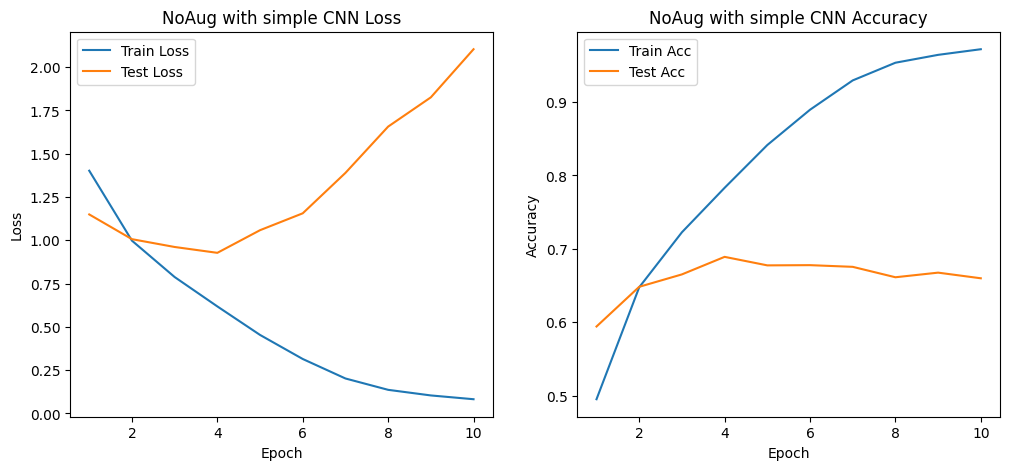

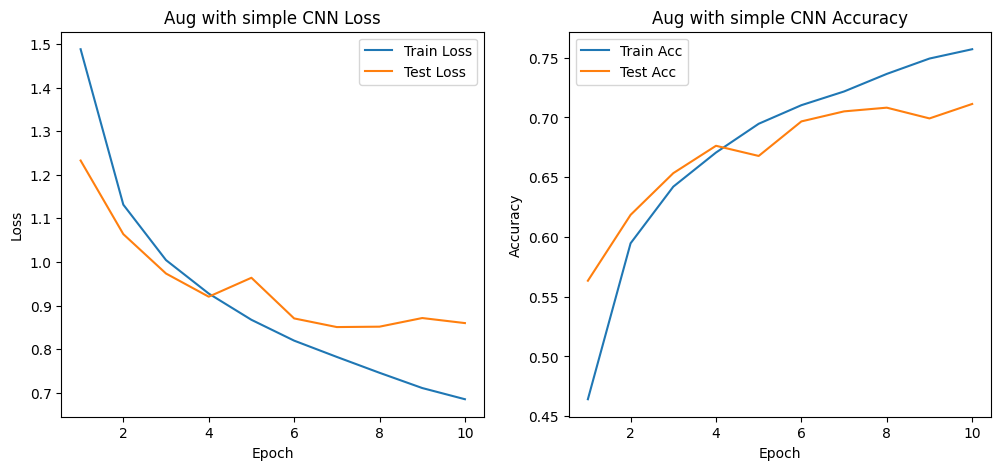

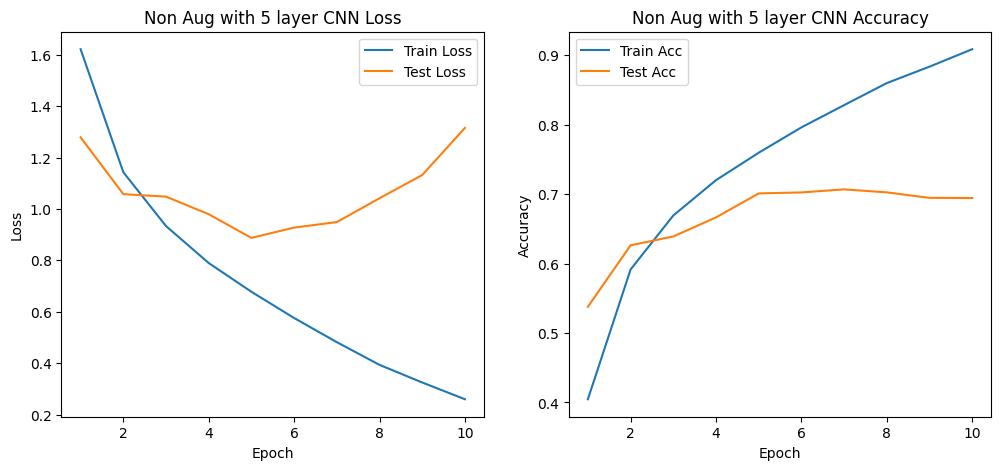

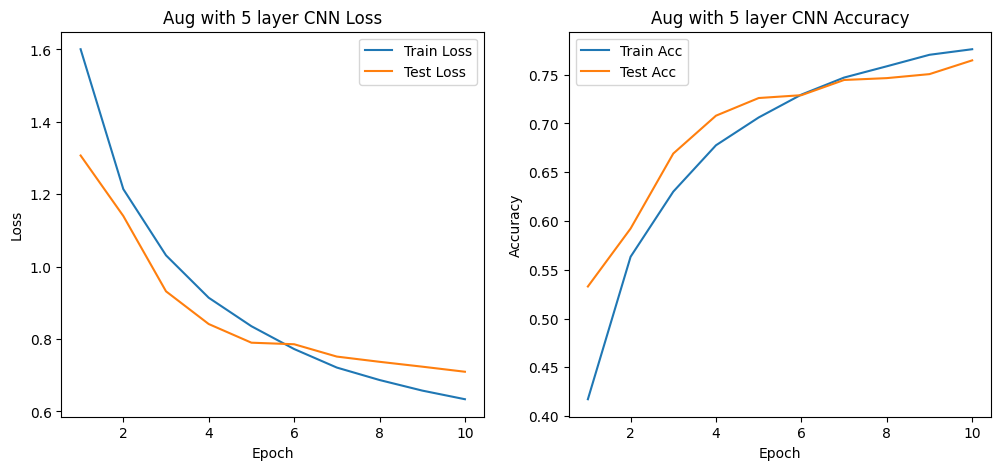

In [15]:
# Plot for no augmentation
plot_metrics(metrics_noaug, title_prefix="NoAug with simple CNN")

# Plot for augmentation
plot_metrics(metrics_aug,  title_prefix="Aug with simple CNN")

plot_metrics(metrics_noaug_deeper,  title_prefix="Non Aug with 5 layer CNN")
plot_metrics(metrics_aug_deeper,  title_prefix="Aug with 5 layer CNN")



In [16]:
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            # labels are one-hot => must find class indices
            label_indices = torch.argmax(labels, dim=1).cpu().numpy()
            all_labels.extend(label_indices)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)

    # Precision/recall/f1 with integer class labels
    precision = precision_score(all_labels, all_preds, average='macro')
    recall    = recall_score(all_labels, all_preds, average='macro')
    f1        = f1_score(all_labels, all_preds, average='macro')
    accuracy  = np.mean(np.array(all_labels) == np.array(all_preds))

    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, precision, recall, f1, cm


No Aug Results:
Accuracy:  0.6599
Precision: 0.6688
Recall:    0.6599
F1-score:  0.6596


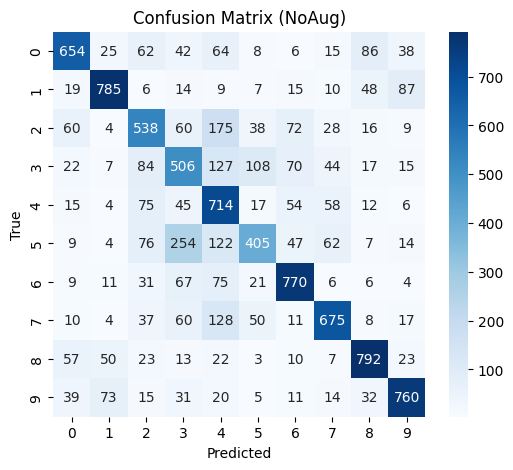

In [17]:
acc_noaug, pre_noaug, rec_noaug, f1_noaug, cm_noaug = evaluate_model(model_noaug, test_loader_noaug)
print("No Aug Results:")
print(f"Accuracy:  {acc_noaug:.4f}")
print(f"Precision: {pre_noaug:.4f}")
print(f"Recall:    {rec_noaug:.4f}")
print(f"F1-score:  {f1_noaug:.4f}")

plt.figure(figsize=(6,5))
sns.heatmap(cm_noaug, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (NoAug)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Aug Results:
Accuracy:  0.7113
Precision: 0.7116
Recall:    0.7113
F1-score:  0.7089


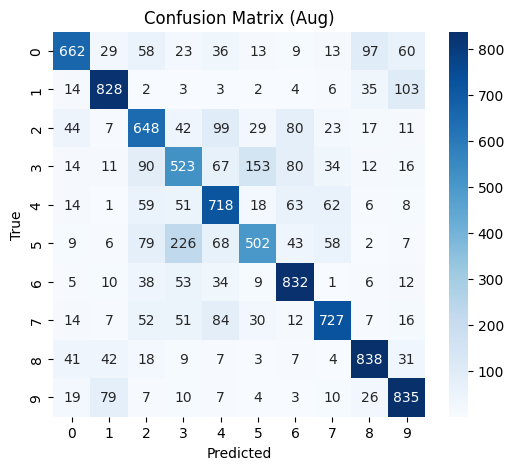

In [18]:
acc_aug, pre_aug, rec_aug, f1_aug, cm_aug = evaluate_model(model_aug, test_loader_aug)
print("Aug Results:")
print(f"Accuracy:  {acc_aug:.4f}")
print(f"Precision: {pre_aug:.4f}")
print(f"Recall:    {rec_aug:.4f}")
print(f"F1-score:  {f1_aug:.4f}")

plt.figure(figsize=(6,5))
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Aug)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Feature maps from conv1 (NoAug model)


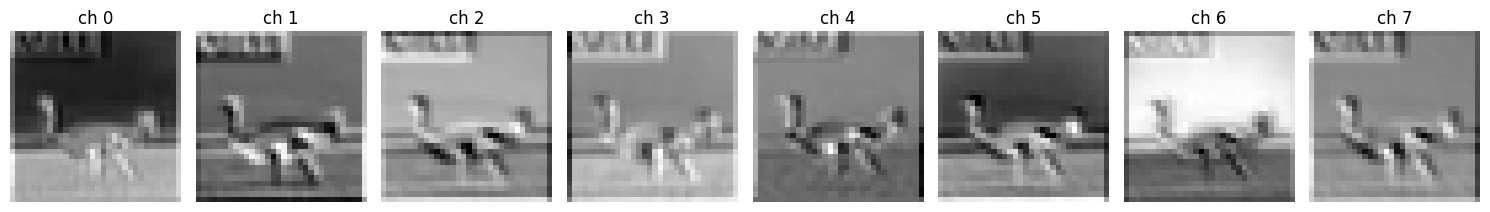

In [19]:
def visualize_feature_maps(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    # Grab 1 batch
    images, _ = next(iter(loader))
    images = images[:1].to(device)  # just take 1 sample

    with torch.no_grad():
        # pass through first conv
        feat = model.conv1(images)  # shape => (1,32,32,32)

    # remove batch dimension
    feat = feat[0]  # shape => (32,32,32)
    feat = feat.cpu().numpy()

    # let's visualize first 8 channels
    n_channels = 8
    fig, axes = plt.subplots(1,n_channels, figsize=(15,3))
    for i in range(n_channels):
        axes[i].imshow(feat[i], cmap='gray')
        axes[i].set_title(f"ch {i}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

print("Feature maps from conv1 (NoAug model)")
visualize_feature_maps(model_noaug, test_loader_noaug)


=== Training with LR=0.001 ===
Using device: cuda
Epoch [1/10] | Train Loss: 1.4140, Acc: 0.4885 | Test Loss: 1.1570, Acc: 0.5969
Epoch [2/10] | Train Loss: 1.0128, Acc: 0.6419 | Test Loss: 1.0193, Acc: 0.6407
Epoch [3/10] | Train Loss: 0.8031, Acc: 0.7166 | Test Loss: 0.9561, Acc: 0.6648
Epoch [4/10] | Train Loss: 0.6428, Acc: 0.7733 | Test Loss: 0.9578, Acc: 0.6723
Epoch [5/10] | Train Loss: 0.4887, Acc: 0.8268 | Test Loss: 1.0179, Acc: 0.6741
Epoch [6/10] | Train Loss: 0.3448, Acc: 0.8801 | Test Loss: 1.1944, Acc: 0.6634
Epoch [7/10] | Train Loss: 0.2364, Acc: 0.9169 | Test Loss: 1.4117, Acc: 0.6627
Epoch [8/10] | Train Loss: 0.1641, Acc: 0.9437 | Test Loss: 1.5822, Acc: 0.6686
Epoch [9/10] | Train Loss: 0.1182, Acc: 0.9594 | Test Loss: 1.8736, Acc: 0.6591
Epoch [10/10] | Train Loss: 0.0988, Acc: 0.9667 | Test Loss: 2.0511, Acc: 0.6594


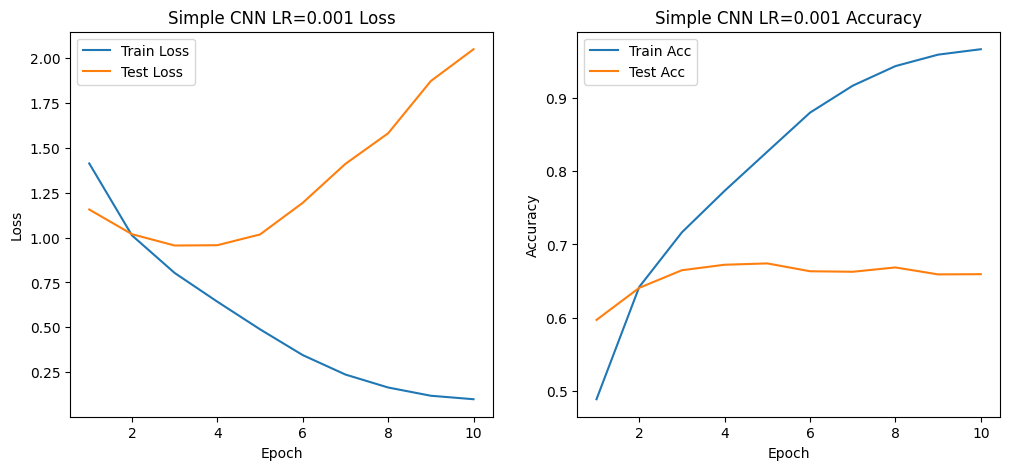

=== Training with LR=0.01 ===
Using device: cuda
Epoch [1/10] | Train Loss: 1.4062, Acc: 0.4935 | Test Loss: 1.1282, Acc: 0.6002
Epoch [2/10] | Train Loss: 0.9719, Acc: 0.6541 | Test Loss: 0.9344, Acc: 0.6707
Epoch [3/10] | Train Loss: 0.7566, Acc: 0.7346 | Test Loss: 0.9182, Acc: 0.6811
Epoch [4/10] | Train Loss: 0.5740, Acc: 0.7987 | Test Loss: 0.9778, Acc: 0.6802
Epoch [5/10] | Train Loss: 0.4089, Acc: 0.8565 | Test Loss: 1.1078, Acc: 0.6661
Epoch [6/10] | Train Loss: 0.2604, Acc: 0.9095 | Test Loss: 1.3182, Acc: 0.6657
Epoch [7/10] | Train Loss: 0.1672, Acc: 0.9427 | Test Loss: 1.4547, Acc: 0.6706
Epoch [8/10] | Train Loss: 0.1150, Acc: 0.9610 | Test Loss: 1.7724, Acc: 0.6659
Epoch [9/10] | Train Loss: 0.0984, Acc: 0.9672 | Test Loss: 1.9525, Acc: 0.6682
Epoch [10/10] | Train Loss: 0.0805, Acc: 0.9735 | Test Loss: 2.1077, Acc: 0.6619


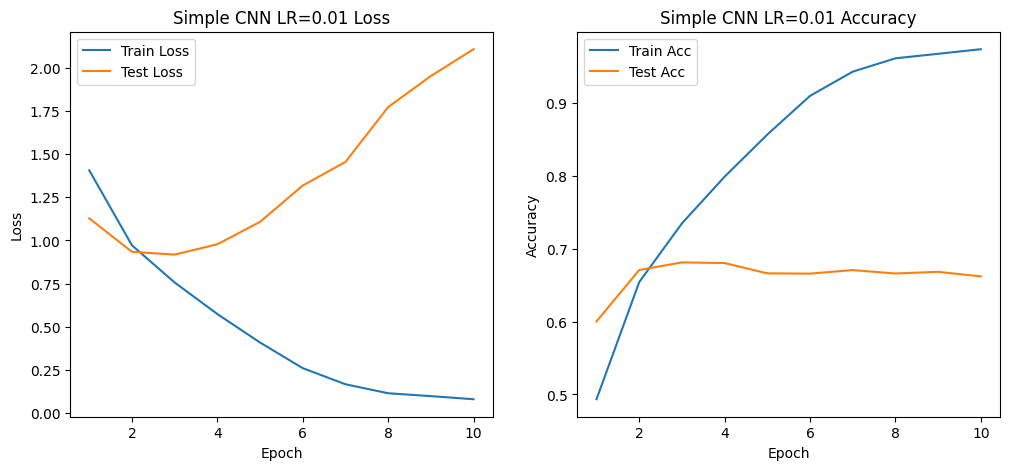

=== Training with LR=0.1 ===
Using device: cuda
Epoch [1/10] | Train Loss: 1.3990, Acc: 0.4981 | Test Loss: 1.1476, Acc: 0.5894
Epoch [2/10] | Train Loss: 1.0007, Acc: 0.6443 | Test Loss: 0.9969, Acc: 0.6489
Epoch [3/10] | Train Loss: 0.8026, Acc: 0.7153 | Test Loss: 0.9753, Acc: 0.6632
Epoch [4/10] | Train Loss: 0.6272, Acc: 0.7789 | Test Loss: 0.9942, Acc: 0.6634
Epoch [5/10] | Train Loss: 0.4397, Acc: 0.8458 | Test Loss: 1.1257, Acc: 0.6734
Epoch [6/10] | Train Loss: 0.2704, Acc: 0.9067 | Test Loss: 1.3152, Acc: 0.6716
Epoch [7/10] | Train Loss: 0.1640, Acc: 0.9457 | Test Loss: 1.6281, Acc: 0.6597
Epoch [8/10] | Train Loss: 0.1138, Acc: 0.9620 | Test Loss: 1.7431, Acc: 0.6697
Epoch [9/10] | Train Loss: 0.0911, Acc: 0.9696 | Test Loss: 1.9653, Acc: 0.6603
Epoch [10/10] | Train Loss: 0.0814, Acc: 0.9724 | Test Loss: 2.3010, Acc: 0.6477


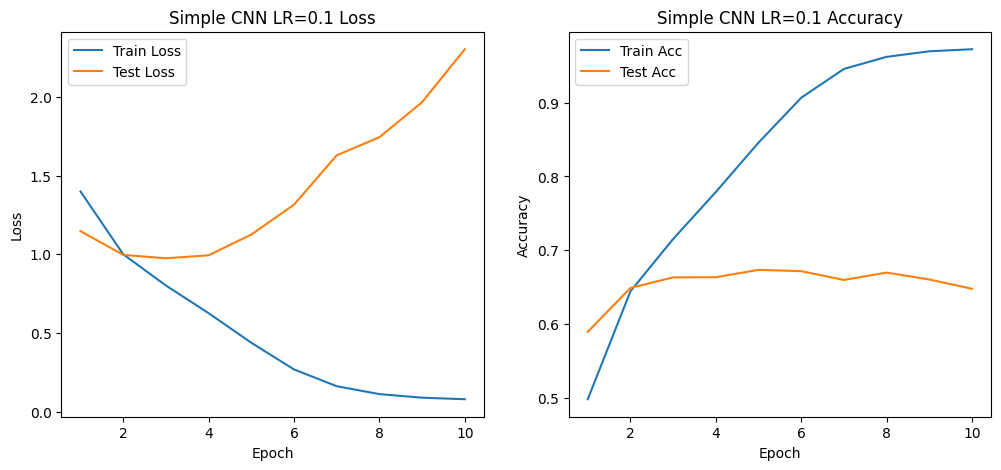

LR | Acc | Prec | Recall | F1
0.001 | 0.6594 | 0.6542 | 0.6594 | 0.6537
0.01 | 0.6619 | 0.6717 | 0.6619 | 0.6651
0.1 | 0.6477 | 0.6636 | 0.6477 | 0.6523


In [20]:
lr_list = [0.001, 0.01, 0.1]
results = []
for lr in lr_list:
    print(f"=== Training with LR={lr} ===")
    model_lr, metrics_lr = train_model(train_loader_noaug, test_loader_noaug,
                                       num_epochs=10, lr=lr)
    acc_lr, pre_lr, rec_lr, f1_lr, cm_lr = evaluate_model(model_lr, test_loader_noaug)
    results.append((lr, acc_lr, pre_lr, rec_lr, f1_lr))
    plot_metrics(metrics_lr, title_prefix=f"Simple CNN LR={lr}")

# Print results in a table
print("LR | Acc | Prec | Recall | F1")
for r in results:
    print(f"{r[0]} | {r[1]:.4f} | {r[2]:.4f} | {r[3]:.4f} | {r[4]:.4f}")


=== Training with LR=0.001 ===
Using device: cuda
Epoch [1/10] | Train Loss: 1.5644, Acc: 0.4299 | Test Loss: 1.3032, Acc: 0.5349
Epoch [2/10] | Train Loss: 1.0828, Acc: 0.6118 | Test Loss: 1.0707, Acc: 0.6155
Epoch [3/10] | Train Loss: 0.8503, Acc: 0.6978 | Test Loss: 0.8916, Acc: 0.6819
Epoch [4/10] | Train Loss: 0.6840, Acc: 0.7585 | Test Loss: 0.8345, Acc: 0.7108
Epoch [5/10] | Train Loss: 0.5555, Acc: 0.8039 | Test Loss: 0.8677, Acc: 0.7200
Epoch [6/10] | Train Loss: 0.4395, Acc: 0.8433 | Test Loss: 0.8974, Acc: 0.7214
Epoch [7/10] | Train Loss: 0.3353, Acc: 0.8806 | Test Loss: 1.0227, Acc: 0.7184
Epoch [8/10] | Train Loss: 0.2588, Acc: 0.9065 | Test Loss: 1.0580, Acc: 0.7268
Epoch [9/10] | Train Loss: 0.1983, Acc: 0.9293 | Test Loss: 1.3435, Acc: 0.7022
Epoch [10/10] | Train Loss: 0.1651, Acc: 0.9411 | Test Loss: 1.3559, Acc: 0.7237


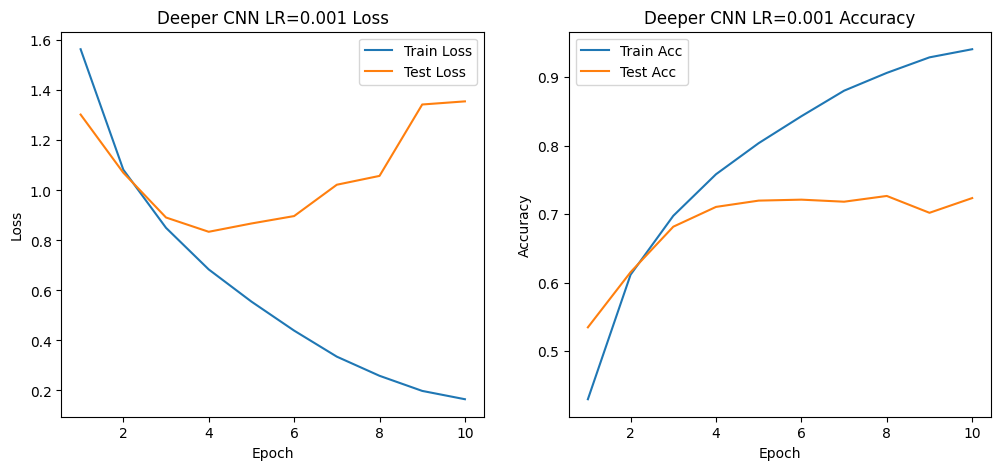

=== Training with LR=0.01 ===
Using device: cuda
Epoch [1/10] | Train Loss: 1.5630, Acc: 0.4311 | Test Loss: 1.3259, Acc: 0.5220
Epoch [2/10] | Train Loss: 1.0935, Acc: 0.6115 | Test Loss: 1.0204, Acc: 0.6356
Epoch [3/10] | Train Loss: 0.8377, Acc: 0.7020 | Test Loss: 0.8635, Acc: 0.6975
Epoch [4/10] | Train Loss: 0.6486, Acc: 0.7702 | Test Loss: 0.8775, Acc: 0.6979
Epoch [5/10] | Train Loss: 0.4806, Acc: 0.8293 | Test Loss: 0.9689, Acc: 0.7043
Epoch [6/10] | Train Loss: 0.3341, Acc: 0.8818 | Test Loss: 1.1142, Acc: 0.6978
Epoch [7/10] | Train Loss: 0.2247, Acc: 0.9176 | Test Loss: 1.2997, Acc: 0.7052
Epoch [8/10] | Train Loss: 0.1640, Acc: 0.9431 | Test Loss: 1.6252, Acc: 0.6827
Epoch [9/10] | Train Loss: 0.1442, Acc: 0.9498 | Test Loss: 1.6137, Acc: 0.6940
Epoch [10/10] | Train Loss: 0.1155, Acc: 0.9611 | Test Loss: 1.7875, Acc: 0.6622


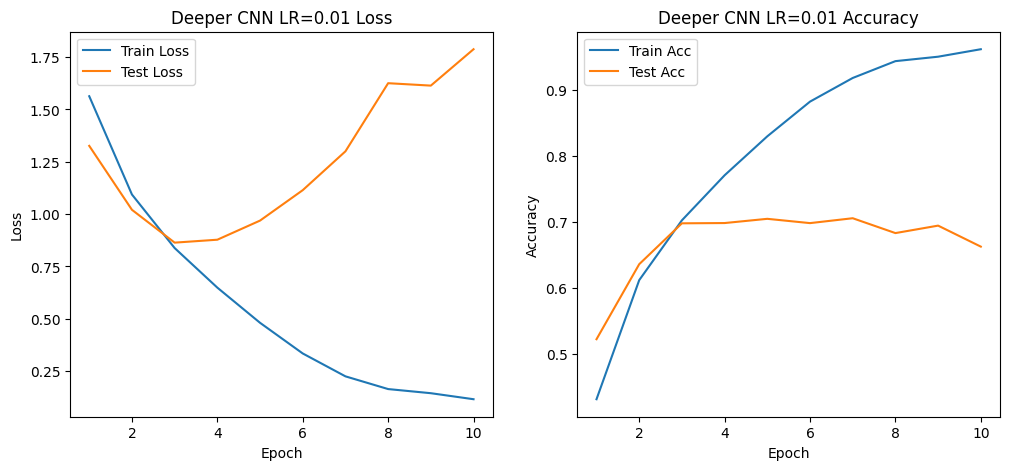

=== Training with LR=0.1 ===
Using device: cuda
Epoch [1/10] | Train Loss: 1.6096, Acc: 0.4108 | Test Loss: 1.2658, Acc: 0.5399
Epoch [2/10] | Train Loss: 1.0819, Acc: 0.6126 | Test Loss: 0.9803, Acc: 0.6562
Epoch [3/10] | Train Loss: 0.8566, Acc: 0.6967 | Test Loss: 0.9319, Acc: 0.6767
Epoch [4/10] | Train Loss: 0.7086, Acc: 0.7505 | Test Loss: 0.8254, Acc: 0.7182
Epoch [5/10] | Train Loss: 0.5844, Acc: 0.7940 | Test Loss: 0.8433, Acc: 0.7188
Epoch [6/10] | Train Loss: 0.4705, Acc: 0.8319 | Test Loss: 0.8642, Acc: 0.7189
Epoch [7/10] | Train Loss: 0.3589, Acc: 0.8719 | Test Loss: 0.9879, Acc: 0.7183
Epoch [8/10] | Train Loss: 0.2724, Acc: 0.9030 | Test Loss: 1.0826, Acc: 0.7170
Epoch [9/10] | Train Loss: 0.2023, Acc: 0.9281 | Test Loss: 1.2902, Acc: 0.7174
Epoch [10/10] | Train Loss: 0.1760, Acc: 0.9383 | Test Loss: 1.4085, Acc: 0.7152


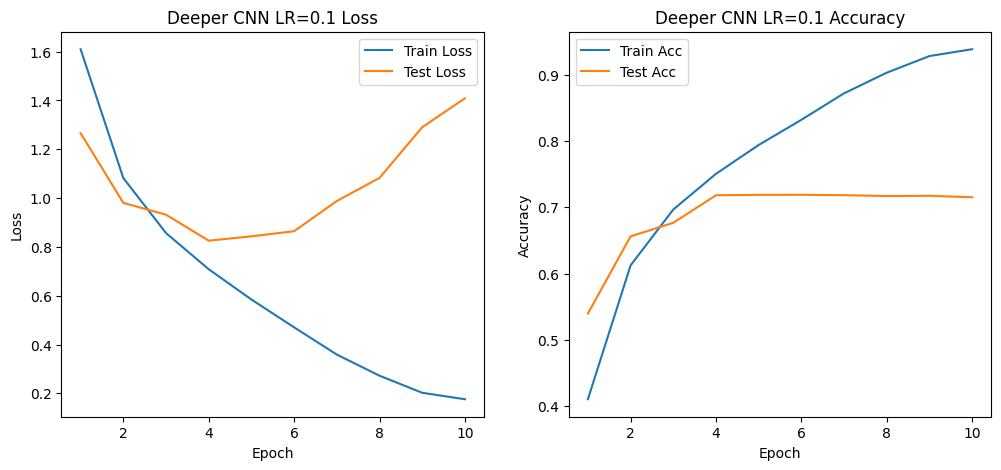

LR | Acc | Prec | Recall | F1
0.001 | 0.7237 | 0.7257 | 0.7237 | 0.7239
0.01 | 0.6622 | 0.6751 | 0.6622 | 0.6647
0.1 | 0.7152 | 0.7164 | 0.7152 | 0.7146


In [21]:
lr_list = [0.001, 0.01, 0.1]
results = []
for lr in lr_list:
    print(f"=== Training with LR={lr} ===")
    model_lr, metrics_lr = train_model(train_loader_noaug, test_loader_noaug,
                                       num_epochs=10, lr=lr, cnn_type="deeper")
    acc_lr, pre_lr, rec_lr, f1_lr, cm_lr = evaluate_model(model_lr, test_loader_noaug)
    results.append((lr, acc_lr, pre_lr, rec_lr, f1_lr))
    plot_metrics(metrics_lr, title_prefix=f"Deeper CNN LR={lr}")


# Print results in a table
print("LR | Acc | Prec | Recall | F1")
for r in results:
    print(f"{r[0]} | {r[1]:.4f} | {r[2]:.4f} | {r[3]:.4f} | {r[4]:.4f}")
